In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from mat73 import loadmat
from matplotlib.ticker import FixedLocator
from sklearn.decomposition import PCA
import pandas as pd


sys.path.append('/home/david/Código/EAI-temporal-large-scale/src')
import utils


%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
paths = np.sort(list(Path('/home/david/Código/EAI-temporal-large-scale/data/Pxx').rglob('*[Mm][Aa][Tt]')))
x = loadmat('/home/david/Código/EAI-temporal-large-scale/data/TimeFreqSettings.mat')
choirs = loadmat('/home/david/Código/EAI-temporal-large-scale/data/Ann_Ch.mat')
frequency = loadmat('/home/david/Código/EAI-temporal-large-scale/data/Ch_Spectr_Descriptor.mat')


paths2 = np.array(paths)
paths2 = np.array(paths[:-1]).reshape(4,7)

# Spectrogram long term

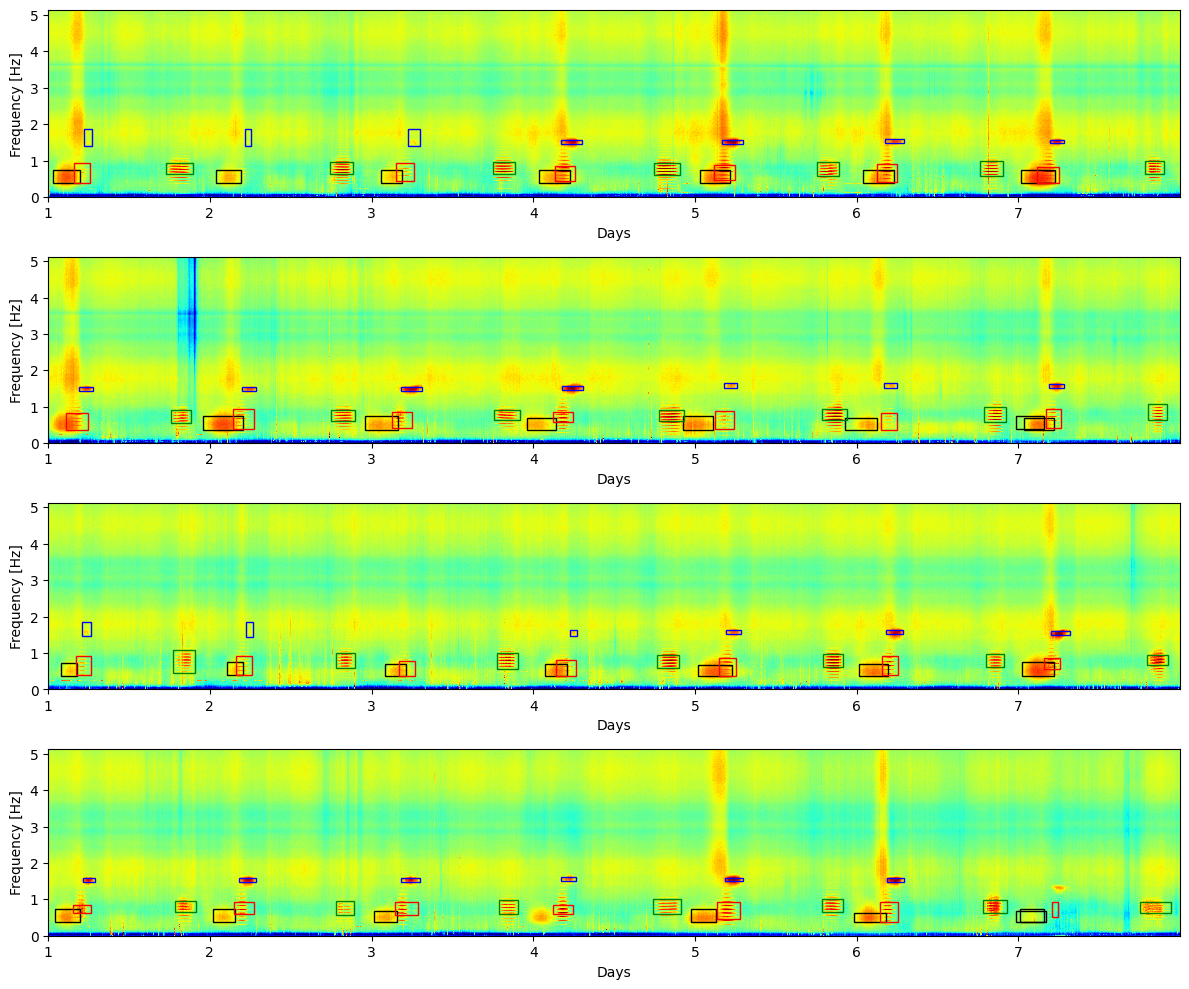

In [3]:
fig, ax = plt.subplots(4,1,figsize=(12,10))

for s in range(paths2.shape[0]):
   Pxx = np.zeros((1025,1))
   for d in range(paths2.shape[1]):
      pxx = loadmat(paths2[s,d])['Pxx']
      if pxx.shape[1]< 1440:
         temp = pxx[:,-1].reshape(pxx.shape[0],1)
         pxx = np.hstack([pxx, np.repeat(temp,1440-pxx.shape[1] ,1)])

      Pxx = np.hstack([Pxx,pxx])

   Sxx = 20*np.log10(Pxx[1:,:])

   ax[s].pcolormesh(Sxx, vmin=np.percentile(Sxx,0.1), vmax=np.percentile(Sxx,99.99), cmap='jet')
   ax[s].set_xlabel('Days')
   ax[s].set_ylabel('Frequency [Hz]')
   ax[s].set_yticklabels(np.linspace(0,11025//2,6, dtype=int)//1000)
   ax[s].xaxis.set_major_locator(FixedLocator(np.linspace(0,7*1440,8, dtype=int)[:-1]))
   ax[s].set_xticklabels(np.linspace(1,7,7, dtype=int))
   ax[s].set_ylim(0,1025)
   ax[s].set_xlim(0,1440*7)


freq = np.linspace(0,11025//2,1025)
event1 = choirs['Ann_Ch2'][:,:-1].reshape(3,4,7)
event2 = choirs['Ann_Ch3'][:,:-1].reshape(3,4,7)
event3 = choirs['Ann_Ch4'][:,:-1].reshape(3,4,7)
event4 = choirs['Ann_Ch5'][:,:-1].reshape(3,4,7)
flow = frequency['BW_fLow'][:28,:].T.reshape(5,4,7)/(11025//2)*1025
fHigh = frequency['BW_fHig'][:28,:].T.reshape(5,4,7)/(11025//2)*1025

for s in range(event1.shape[1]):
   for d in range(event1.shape[2]):
      e1 = event1[:,s,d]
      e2 = event2[:,s,d]
      e3 = event3[:,s,d]
      e4 = event4[:,s,d]

      utils.plotrect(ax[s],e1[0],e1[2],flow[1,s,d],fHigh[1,s,d],'black',d)
      utils.plotrect(ax[s],e2[0],e2[2],flow[2,s,d],fHigh[2,s,d],'red',d)
      utils.plotrect(ax[s],e3[0],e3[2],flow[3,s,d],fHigh[3,s,d],'blue',d)
      utils.plotrect(ax[s],e4[0],e4[2],flow[4,s,d],fHigh[4,s,d],'green',d)


fig.tight_layout()
fig.show()


# Spectrogram threshold

In [4]:
fig, ax = plt.subplots(4,1,figsize=(12,10))

for s in range(paths2.shape[0]):
   Pxx = np.zeros((1025,1))
   for d in range(paths2.shape[1]):
      pxx = loadmat(paths2[s,d])['Pxx'][:,:1425]

      Pxx = np.hstack([Pxx,pxx])

   Sxx = 20*np.log10(Pxx[1:,:])

   mask = Sxx < np.percentile(Sxx, 50)

   Sxx2 = Sxx.copy()
   Sxx2[mask] = Sxx.min()

   ax[s].pcolormesh(Sxx2, vmin=np.percentile(Sxx,0.1), vmax=np.percentile(Sxx,99.99), cmap='jet')
   ax[s].set_xlabel('Days')
   ax[s].set_ylabel('Frequency [Hz]')
   ax[s].set_yticklabels(np.linspace(0,11025//2,6, dtype=int)//1000)
   ax[s].xaxis.set_major_locator(FixedLocator(np.linspace(0,7*1425,8, dtype=int)[:-1]))
   ax[s].set_xticklabels(np.linspace(1,7,7, dtype=int))
fig.tight_layout()
fig.show()

: 

: 

# Spectrogram Equalizated

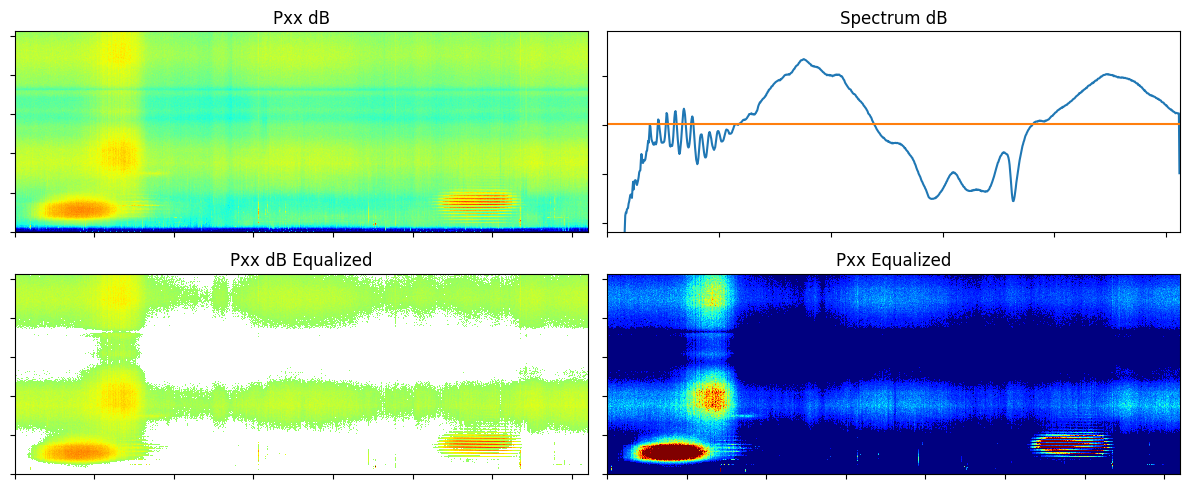

In [65]:
for m in paths.ravel():
   pxx = loadmat(m)['Pxx']
   pxx_db = 20*np.log10(pxx)

   fig,ax = plt.subplots(2,2,figsize=(12,5))
   ax[0,0].pcolormesh(pxx_db, cmap='jet', vmin=np.percentile(pxx_db,0.1), vmax=np.percentile(pxx_db,99.9999))
   ax[0,0].set_title('Pxx dB')
   ax[0,0].set_xticklabels('')
   ax[0,0].set_yticklabels('')


   ax[0,1].plot(pxx_db.mean(axis=1))
   ax[0,1].set_ylim(np.percentile(pxx_db,5), np.percentile(pxx_db,95))
   ax[0,1].set_title('Spectrum dB')
   th = np.percentile(pxx_db,50)
   ax[0,1].plot([0, 1025], [th, th])
   ax[0,1].set_xlim(0,1025)
   ax[0,1].set_xticklabels('')
   ax[0,1].set_yticklabels('')


   pxx_mask = pxx_db < th
   pxx_db_mask = pxx_db.copy()
   pxx_db_mask[pxx_mask] = None
   pxx_eq = pxx.copy()
   pxx_eq[pxx_mask] = 0

   ax[1,0].pcolormesh(pxx_db_mask, cmap='jet', vmin=np.percentile(pxx_db,0.1), vmax=np.percentile(pxx_db,99.9999))
   ax[1,0].set_title('Pxx dB Equalized')
   ax[1,0].set_xticklabels('')
   ax[1,0].set_yticklabels('')


   ax[1,1].pcolormesh(pxx_eq, cmap='jet', vmin=0, vmax=np.percentile(pxx_eq,99))
   ax[1,1].set_title('Pxx Equalized')
   ax[1,1].set_xticklabels('')
   ax[1,1].set_yticklabels('')

   fig.tight_layout()
   fig.show()

   break

# Choirs mask

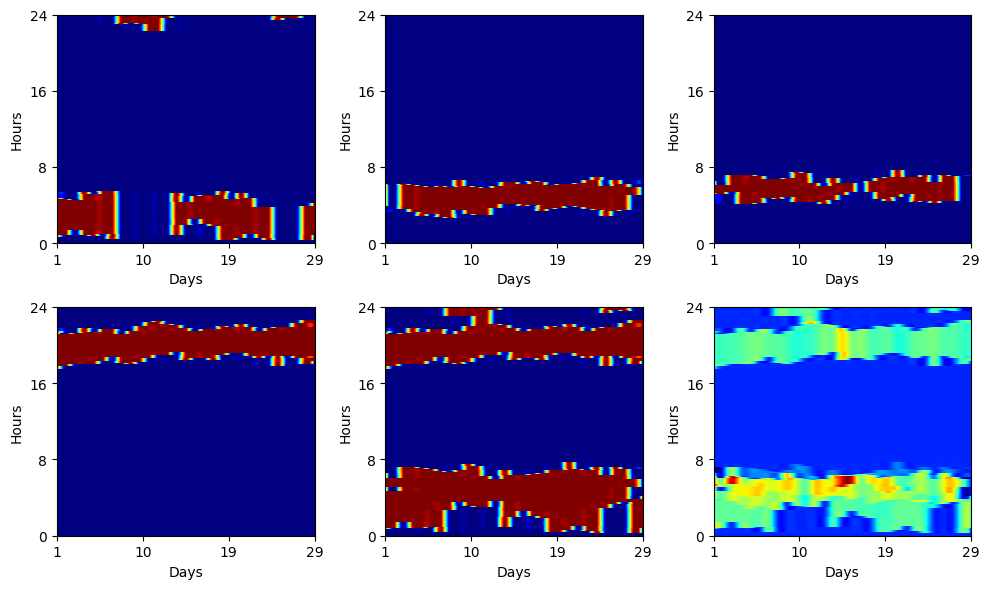

In [90]:
freq = np.linspace(0,11025//2,1025)
event1 = choirs['Ann_Ch2']
event2 = choirs['Ann_Ch3']
event3 = choirs['Ann_Ch4']
event4 = choirs['Ann_Ch5']
flow = frequency['BW_fLow'].T/(11025//2)*1025
fHigh = frequency['BW_fHig'].T/(11025//2)*1025


events = [event1, event2, event3, event4]


fig, ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.ravel()

for e in range(len(events)):
   act = []
   for ind, m in enumerate(paths.ravel()):
   
      mask = np.zeros((1025,1440))

      ev = events[e]
      mask = utils.apply_mask(mask,ev[0,ind],ev[2,ind],
                              flow[int(e+1),ind],fHigh[int(e+1),ind])
      act.append(mask.sum(axis=0))


   act = np.array(act)
   act[act > 1] = 1
   act = utils.interpolate_index(act,50,1)
   ax[e].pcolormesh(act.T, vmin=0, vmax=1, cmap='jet')

   ax[e].set_xlabel('Days')
   ax[e].set_ylabel('Hours')
   ax[e].xaxis.set_major_locator(
         FixedLocator(np.linspace(0, 29*50, 4, dtype=int)))
   ax[e].set_xticklabels(np.linspace(1, 29, 4, dtype=int))
   ax[e].yaxis.set_major_locator(
         FixedLocator(np.linspace(0, 1440, 4, dtype=int)))
   ax[e].set_yticklabels(np.linspace(0, 24, 4, dtype=int))

   


act = []
act2 = []
for ind, m in enumerate(paths.ravel()):
      pxx = loadmat(m)['Pxx']
      mask = np.zeros((1025,1440))
      for e in range(len(events)):
      
         ev = events[e]
         mask = utils.apply_mask(mask,ev[0,ind],ev[2,ind],
                                 flow[int(e+1),ind],fHigh[int(e+1),ind])
   
      temp = mask*mask

      act2.append(temp.sum(axis=0))
      act.append(mask.sum(axis=0))
      


act = np.array(act)
act2 = np.array(act2)

act[act > 1] = 1
act = utils.interpolate_index(act,50,1)
act2 = utils.interpolate_index(act2,50,1)
ax[4].pcolormesh(act.T, vmin=0, vmax=1, cmap='jet')
ax[4].set_xlabel('Days')
ax[4].set_ylabel('Hours')
ax[4].xaxis.set_major_locator(
         FixedLocator(np.linspace(0, 29*50, 4, dtype=int)))
ax[4].set_xticklabels(np.linspace(1, 29, 4, dtype=int))
ax[4].yaxis.set_major_locator(
         FixedLocator(np.linspace(0, 1440, 4, dtype=int)))
ax[4].set_yticklabels(np.linspace(0, 24, 4, dtype=int))


ax[5].pcolormesh(act2.T,  cmap='jet')
ax[5].set_xlabel('Days')
ax[5].set_ylabel('Hours')
ax[5].xaxis.set_major_locator(
         FixedLocator(np.linspace(0, 29*50, 4, dtype=int)))
ax[5].set_xticklabels(np.linspace(1, 29, 4, dtype=int))
ax[5].yaxis.set_major_locator(
         FixedLocator(np.linspace(0, 1440, 4, dtype=int)))
ax[5].set_yticklabels(np.linspace(0, 24, 4, dtype=int))

fig.tight_layout()
fig.show()

In [86]:
ax[5].pcolormesh(act2.T,  cmap='jet')



# Index Calculated

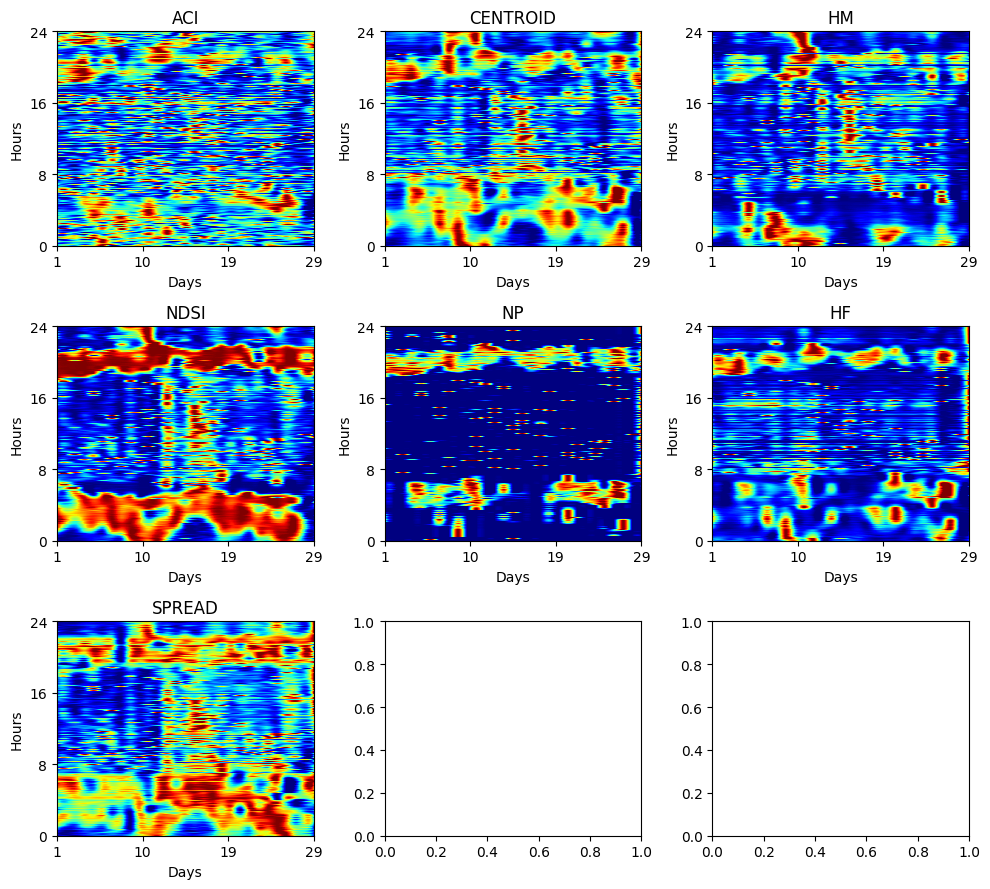

In [4]:
aci,adi,hm, ndsi, npeaks, hf, centroid, spread = utils.get_indices(paths.ravel(), 
                                                       fs = 11025, 
                                                       equalized=False)

acoustic_map = utils.AcousticMap(aci, adi,hm, ndsi,npeaks, hf,centroid, spread)

fig, ax = acoustic_map.showMap(normalized=True)

#ax[2,1].pcolormesh(Xp[:,0].reshape(1425,29))

# PCA

In [14]:
from sklearn.preprocessing import MinMaxScaler


def get_matrix(indices:list):
    mat = []
    for l in indices:
        l = np.array([x[:1425] for x in l])
        scaler = MinMaxScaler()
        l = scaler.fit_transform(l)
        mat.append(l.ravel())
    mat = np.array(mat).T
    temp = np.linspace(0,23,1440,True).reshape(1440,1)[:1425,:]
    temp = np.repeat(temp.T,29,0).ravel()
    temp = temp.reshape(temp.shape[0],1)
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(temp)

    mat = np.hstack([mat,temp])


    return mat


#aci, adi,hm, ndsi,npeaks, hf,centroid, spread = acoustic_map.normalizeIndices()
X = get_matrix([aci,hm, ndsi,npeaks, hf,centroid, spread])
print(X.shape)


pca = PCA(n_components=7)
Xp = pca.fit_transform(X)

(41325, 8)


In [16]:
print(pca.explained_variance_ratio_)


[0.42943424 0.17727545 0.13075107 0.0906582  0.06655881 0.04293053
 0.03596557]


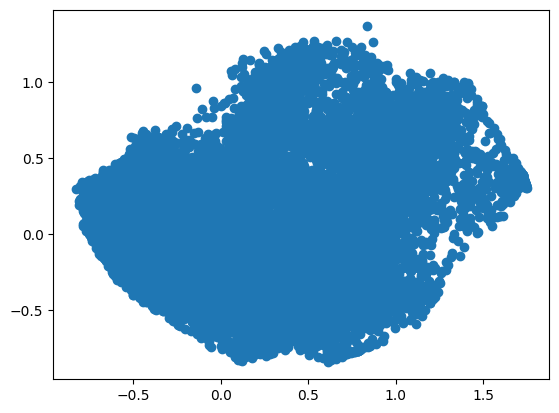

In [17]:
plt.figure()

#plt.pcolormesh(Xp)
plt.scatter(Xp[:,0], Xp[:,1])
plt.show()

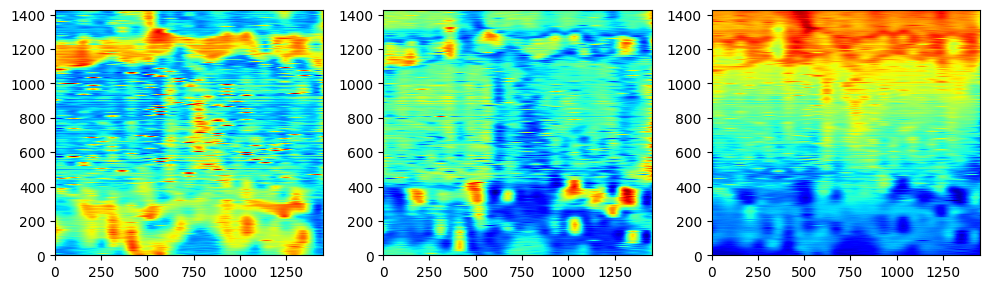

In [34]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
d1 = Xp[:,0].reshape(29,1425).T
d2 = Xp[:,1].reshape(29,1425).T
d3 = Xp[:,2].reshape(29,1425).T

D1 = utils.interpolate_index(d1,1,50)
D2 = utils.interpolate_index(d2,1,50)
D3 = utils.interpolate_index(d3,1,50)

ax[0].pcolormesh(D1, cmap='jet')
ax[1].pcolormesh(D2, cmap='jet')
ax[2].pcolormesh(D3, cmap='jet')

fig.tight_layout()

fig.show()